<a href="https://colab.research.google.com/github/Kalyan1210/GitCode_Analytics/blob/main/delivery_time_prediction_doordash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import data
import pandas as pd

df = pd.read_csv('historical_data.csv')

In [ ]:
#know your data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [ ]:
#Find missing values
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [ ]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load data
df = pd.read_csv('historical_data.csv')

# Convert 'created_at' and 'actual_delivery_time' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Calculate delivery time in minutes
df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Drop rows with null target values
df = df.dropna(subset=['delivery_time'])

# Handle missing values in features
numeric_features = ['market_id', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
                    'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders',
                    'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']
categorical_features = ['store_primary_category']




In [ ]:
df['delivery_time'].mean()

48.47095623059349

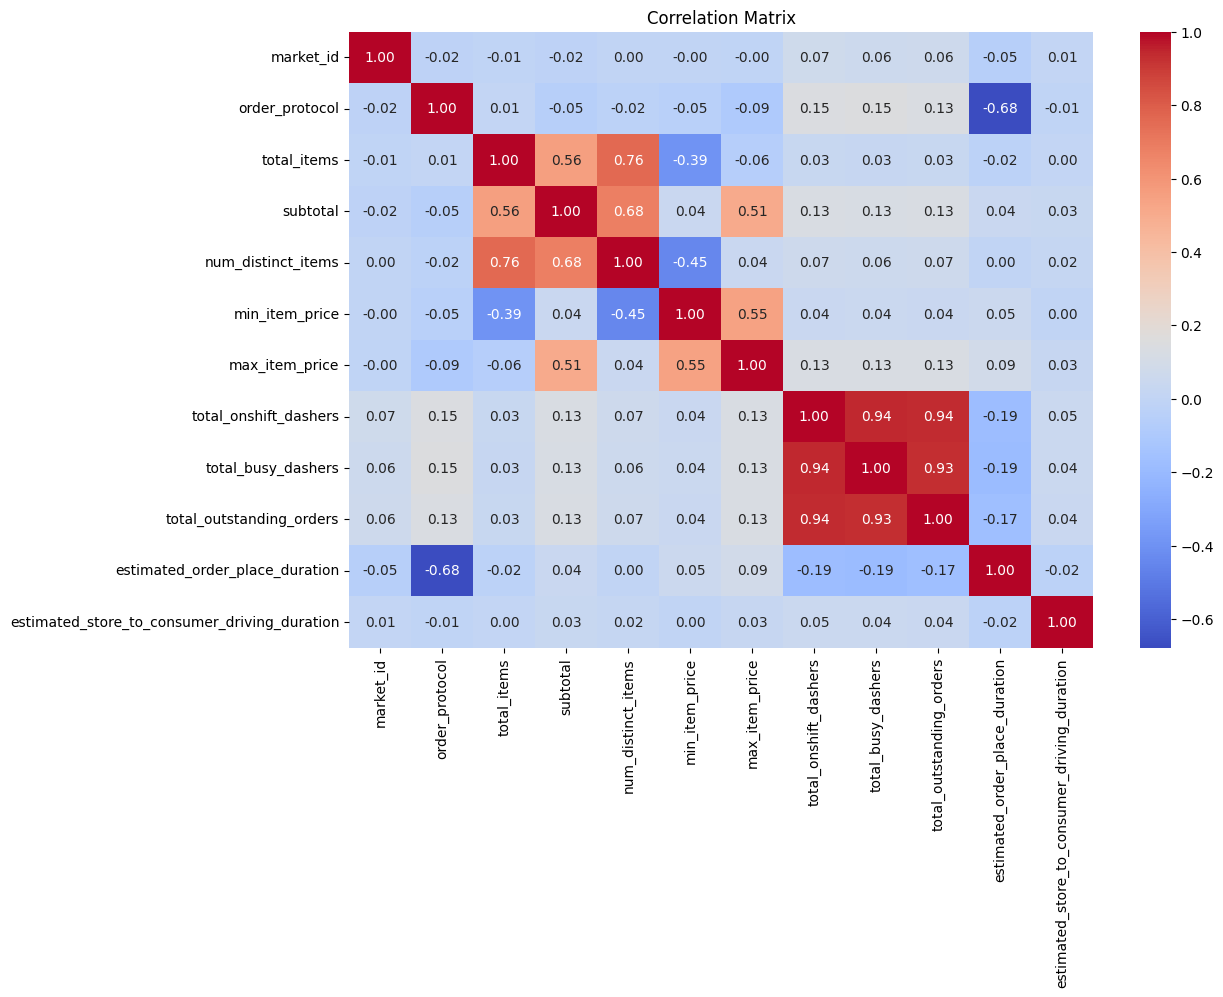

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare the data for VIF calculation
X_vif = df[numeric_features].dropna()

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

print(vif_data)

                                         Feature        VIF
0                                      market_id   4.876284
1                                 order_protocol   4.298029
2                                    total_items   6.183940
3                                       subtotal  11.018354
4                             num_distinct_items  14.397646
5                                 min_item_price   5.670905
6                                 max_item_price  11.879665
7                          total_onshift_dashers  31.475717
8                             total_busy_dashers  29.961812
9                       total_outstanding_orders  21.811580
10                estimated_order_place_duration   8.893089
11  estimated_store_to_consumer_driving_duration   6.600097


In [ ]:
# Preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into features and target
X = df.drop(columns=['created_at', 'actual_delivery_time', 'delivery_time'])
y = df['delivery_time']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Model selection - Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_transformed, y_train)

# Predict on test set
y_pred = model.predict(X_test_transformed)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')